In [71]:
import pandas as pd
import sys
sys.path.append("FinNLP/")
from finnlp.data_sources.news.finnhub_date_range import Finnhub_Date_Range
from finnlp.data_sources.news.yahoo_streaming import Yahoo_Date_Range
from datasets import load_dataset

STK_QUT = pd.read_csv('STK_QUT.csv')
STK_IEM = pd.read_csv('STK_IEM.csv',encoding='EUC-KR')

data = list(STK_IEM['tck_iem_cd'].unique())
#name data
name_data = list(STK_IEM['fc_sec_eng_nm'].unique())
named_data = [ x.split() for x in name_data]
name_data = [ " ".join(x) for x in named_data]

#ticker data
ticker_data = [ x.split()[0] for x in data]

# Sentiment Visualization

In [2]:
from datasets import load_dataset ,load_from_disk
import pandas as pd
from tqdm import tqdm

dataset_path =[]
dataset_list= []
sentiment_model_names = ['distilroberta','Bert+','deberta','finBert']
mrm_dataset = load_from_disk('data/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')
ahm_dataset = load_from_disk('data/clean_data/ahmedrachid/FinancialBERT-Sentiment-Analysis')
nick_dataset= load_from_disk('data/nickmuchi/deberta-v3-base-finetuned-finance-text-classification')
pros_dataset= load_from_disk('data/ProsusAI/finbert')
dataset_date =load_dataset('sehyun66/Finnhub-News','clean',split='clean')

mrm_dataframe = pd.DataFrame(mrm_dataset)
ahm_dataframe = pd.DataFrame(ahm_dataset)
nick_dataframe = pd.DataFrame(nick_dataset)
pros_dataframe = pd.DataFrame(pros_dataset)
dataset_date = pd.DataFrame(dataset_date)

/home/ssu36/anaconda3/envs/tiger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np


In [5]:
sentiment_df_list =[]

sentiment_df_list.append(mrm_dataframe)
sentiment_df_list.append(ahm_dataframe)
sentiment_df_list.append(nick_dataframe)
sentiment_df_list.append(pros_dataframe)

for idx,df in enumerate(sentiment_df_list):
  df['headline_label'] = df['headline_sentiment'].apply(lambda x: max(x,key=x.get))
  df['summary_label']= df['summary_sentiment'].apply(lambda x: max(x,key=x.get))
  df['negative_sentiment']= df['headline_sentiment'].apply(lambda x: float(x['negative']))


In [82]:

result_list =[]


for idx,df in enumerate(sentiment_df_list):
  df['headline_label'] = df['headline_sentiment'].apply(lambda x: max(x,key=x.get))
  df['summary_label']= df['summary_sentiment'].apply(lambda x: max(x,key=x.get))
  df['negative_sentiment']= df['headline_sentiment'].apply(lambda x: float(x['negative']))
  
  #scale negative_sentiment
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(np.array(df['negative_sentiment']).reshape(-1,1))
  df['negative_sentiment'] = scaled_data
  
  #date time processing
  df =pd.concat([dataset_date[['datetime','related','source']],df],axis=1  )
  df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
  df=df.rename(columns ={'datetime':'date','related':'ticker'})
  
  ##stock data preprocessing
  columns =['date','ticker','open','high','low','end','trading','buysum','sellsum']
  STK_QUT.columns =columns
  STK_QUT['date'] = pd.to_datetime(STK_QUT['date'], format='%Y%m%d')
  
  
  average_sentiments = df.groupby(['ticker', 'date'])['negative_sentiment'].mean().reset_index()
  new_df = STK_QUT.merge(average_sentiments, on=['ticker', 'date'], how='left')
  #sentiment to feature
  new_df['negative_sentiment']= df['negative_sentiment'].fillna(0)
  new_df['headline_label']= df['headline_label'].fillna(0)
  new_df.loc[new_df['headline_label']=='negative','headline_label'] = -1
  new_df.loc[new_df['headline_label']=='postive','headline_label'] = 1
  new_df.loc[new_df['headline_label']=='neutral','headline_label'] = 0
  new_df = new_df.fillna(0)
  #save feature
  feature = ['headline_label','negative_sentiment']
  
  result_list.append(new_df)
  

In [59]:
grouped = df.groupby(['date', 'ticker']).mean('negative_sentiment')


In [84]:
result_list[0]

,date,ticker,open,high,low,end,trading,buysum,sellsum,negative_sentiment,headline_label
0,2023-01-03,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0,0.924949,-1
1,2023-01-03,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0,-0.717191,-1
2,2023-01-03,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0,0.548851,-1
3,2023-01-03,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0,0.638545,-1
4,2023-01-03,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0,0.245940,-1
...,...,...,...,...,...,...,...,...,...,...,...
455333,2023-08-30,BLZE,5.9900,6.1290,5.8300,5.8600,443470.0,205162.0,238308.0,0.000000,0
455334,2023-08-30,ELDN,1.4800,1.5794,1.4100,1.4900,13462.0,5492.0,7970.0,0.000000,0
455335,2023-08-30,BMBL,15.9000,16.4400,15.7900,16.3200,1030250.0,576506.0,453744.0,0.000000,0
455336,2023-08-30,PLRX,16.7900,16.7900,16.2250,16.7100,319531.0,138554.0,180977.0,0.000000,0


In [ ]:
sentiment_df_list[0]

In [ ]:
STK_QUT['negative_sentiments'] = STK_QUT.apply(lambda x: df[(df['ticker']==x['ticker'])&(df['date']==x['date'])]['negative_sentiment'].mean())

In [58]:
STK_QUT['ticker']

0          NVDA
1          APLT
2           ANY
3          CLRB
4         NYMTM
          ...  
455333     BLZE
455334     ELDN
455335     BMBL
455336     PLRX
455337     CNDT
Name: ticker, Length: 455338, dtype: object

In [ ]:
result_list[0]

In [39]:
negative_df=sentiment_df_list[0]['headline_sentiment'].apply(lambda x: x['negative'] if isinstance(x,dict)  else 0)

In [48]:
negative_df.columns =['value']

In [56]:
negative_df=negative_df.astype(float)

In [85]:
import pickle

for idx,data in enumerate(result_list):
  with open(f'data/LSTM_data/data_{idx}','wb') as f:
    pickle.dump(data,f)

In [ ]:
label_count_list =[]
for idx in range(len(sentiment_df_list)):
  groups = sentiment_df_list[idx].groupby('headline_label')
  label_count = {}
  label_count['total'] = len(sentiment_df_list[i])
  for group in groups:
    label_count[group[0]] = len(group[1])
  label_count_list.append(label_count)

In [ ]:

for idx,label_count in enumerate(label_count_list):
  plt.title(sentiment_model_names[idx])
  ratio = list(label_count.values())[1:]
  labels = list(label_count.keys())[1:]
  plt.gca().axis("equal")
  pie =plt.pie(ratio, startangle=0,autopct='%.1f%%',colors=[plt.cm.Set1(i) for i in range(0,4)])
  handles = []
  for i, l in enumerate(labels):
      handles.append(matplotlib.patches.Patch(color=plt.cm.Set1((i)/8.), label=l))
  plt.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")
  plt.gcf().text(0.93,0.04,"* out of competition since 2006", ha="right")
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
  plt.show()

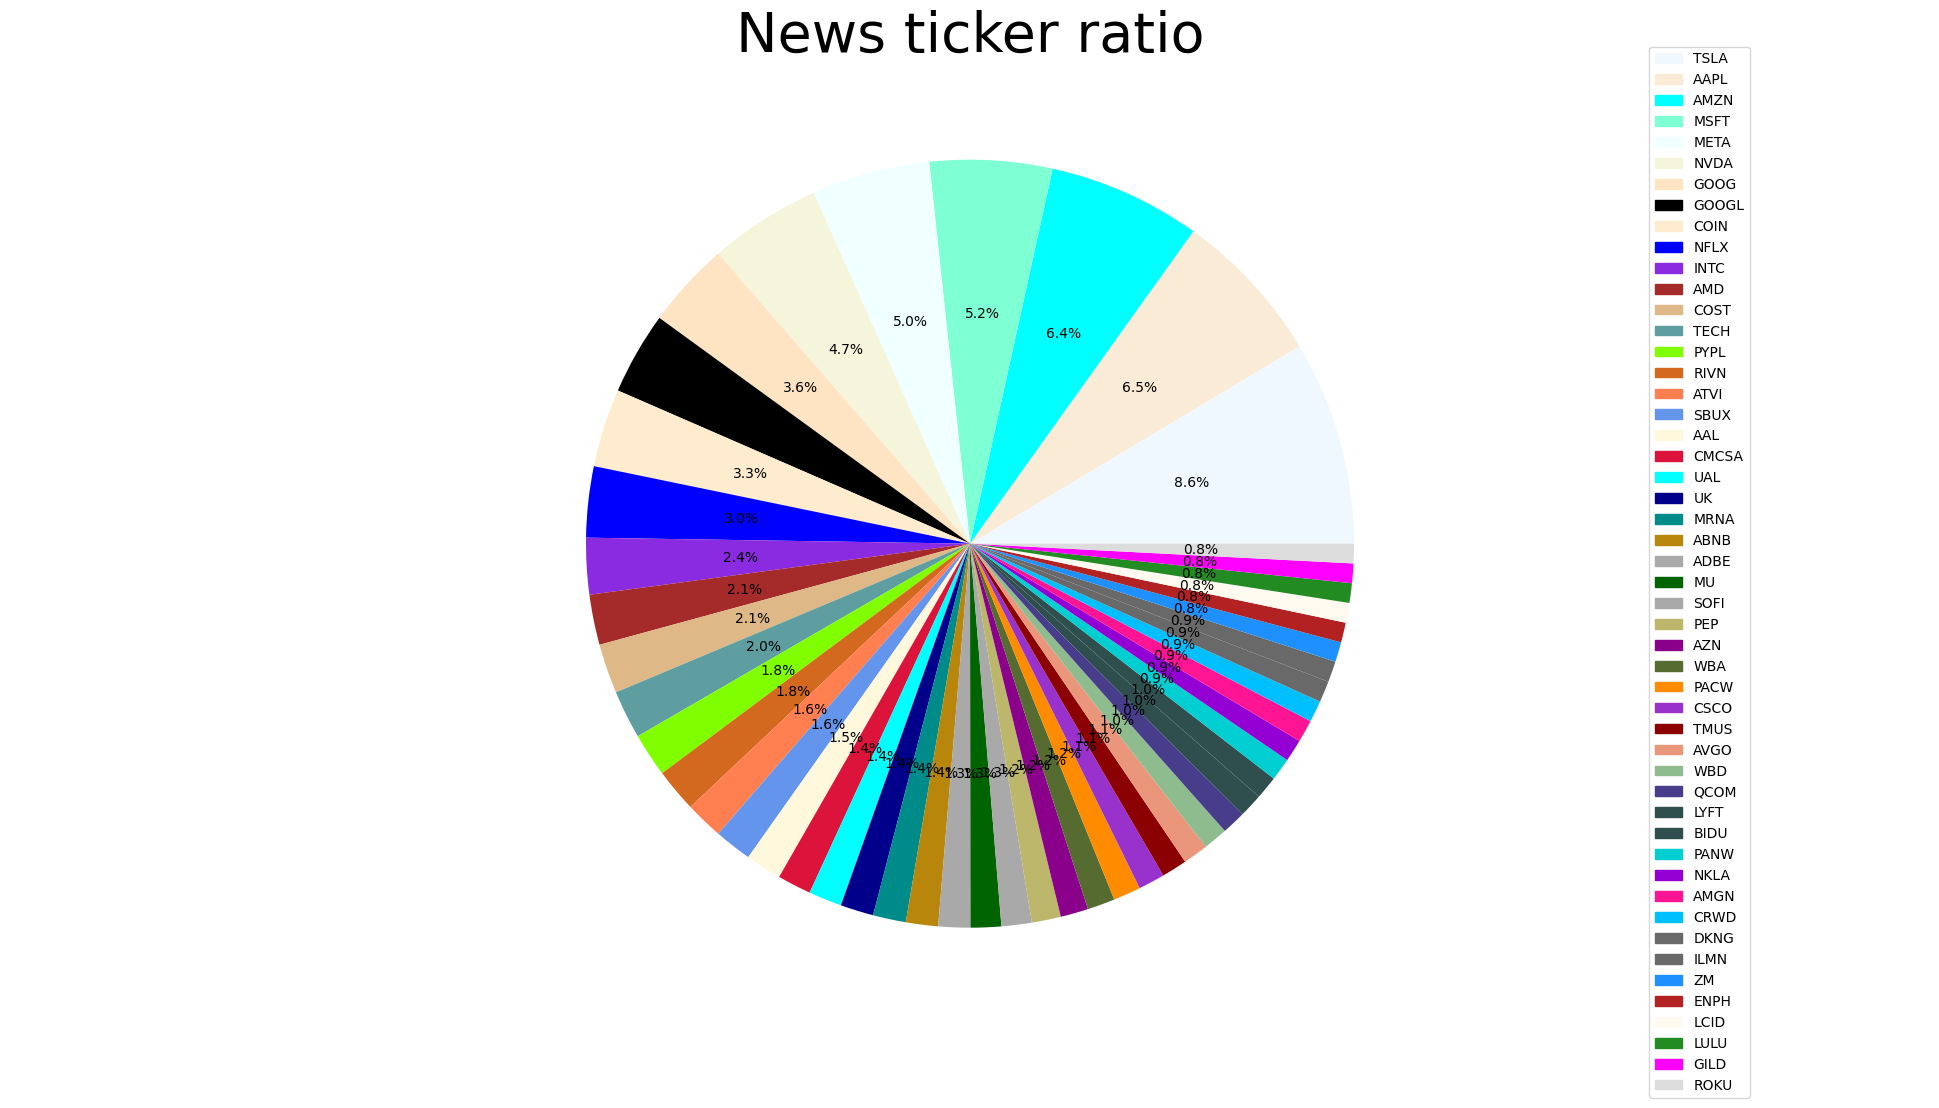

In [63]:
import matplotlib.pyplot as plt
import matplotlib

groups=dataset_date.groupby('related')
fig, ax = plt.subplots(figsize=(12, 6))  # subplot 크기 설정
value_list = [len(group[1]) for group in groups]
labels_list = [group[0] for group in groups]
sorted_data = sorted(zip(value_list, labels_list),reverse=True)  # value_list를 기준으로 오름차순 정렬
# 정렬된 결과를 다시 얻음
value_list, labels_list = zip(*sorted_data)
# 출력

plt.title("News ticker ratio",fontsize=40)
ratio = value_list[:50]
labels = labels_list[:50]
ax.axis("equal")
ax.pie(ratio, startangle=0,autopct='%.1f%%',colors=list(matplotlib.colors.CSS4_COLORS.values()))
center_x = 0.5  # x 중심 좌표
center_y = 0.8  # y 중심 좌표
radius = 0.8   # 파이 차트의 반지
ax.set_position([center_x - radius, center_y - radius+10, 2 * radius, 2 * radius])
handles = []
for i, l in enumerate(labels):
    handles.append(matplotlib.patches.Patch(color=list(matplotlib.colors.CSS4_COLORS.values())[i], label=l))
ax.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")
# ax.subplots_adjust(left=0.2, bottom=0.1, right=1.5)
plt.show()

In [24]:
context = dataset_date[['datetime','related','summary','headline']]
context['datetime'] =context['datetime'].apply(lambda x: pd.to_datetime(x, unit='ms'))
results = [pd.concat([context,x[sentiment_columns]],axis=1) for x in sentiment_df_list]


In [62]:
df =results[0][results[2]['related']=='NVDA']

In [67]:
df[df['summary_label']=='postive'].iloc[0]['headline_sentiment']

{'postive': '0.24158883094787598',
 'negative': '0.3318602740764618',
 'neutral': '0.25972044467926025'}

In [ ]:
for text in list(df[df['summary_label']=='postive']['summary']):
  print(text)
  print('----------------------\n')

In [105]:
No_list=['BHFAL']
ticker_data = list(filter(lambda x: x not in No_list, ticker_data))

for index,result in enumerate(results):
  sentiment_results = pd.DataFrame(columns=['ticker','summary_postive_num','summary_negative_num','headline_postive_num','headline_negative_num','total'])

  for ticker in tqdm(ticker_data):
    groups=result.groupby('related')
    df = groups.get_group(ticker)
    summaray_postive_num=len(df[df['summary_label']=='postive'])
    summary_negative_num=len( df[df['summary_label']=='negative'])
    headline__postive_num=len(df[df['summary_label']=='postive'])
    headline_negative_num=len( df[df['summary_label']=='negative'])
    new_row  ={'ticker': ticker,'summary_postive_num':summaray_postive_num,'summary_negative_num':summary_negative_num,'headline_postive_num':headline__postive_num,'headline_negative_num':headline_negative_num,'total':len(df)}
    sentiment_results =pd.concat([sentiment_results,pd.DataFrame([new_row])] ,ignore_index=True)

  sentiment_results.to_pickle(f'data/results/sentiment_{index}.pkl')

  0%|          | 2/2742 [00:00<02:52, 15.89it/s]

100%|██████████| 2742/2742 [02:41<00:00, 16.94it/s]


# Visualize Ticker News Number

In [53]:
dataset= load_dataset('sehyun66/Finnhub-News','clean',split='clean')
df = pd.DataFrame(dataset)

In [59]:
groups = df.groupby('related').

In [ ]:
groups.get_group('BPMC')

In [74]:
value_list = [len(group[1]) for group in groups]
label_list = [group[0] for group in groups]

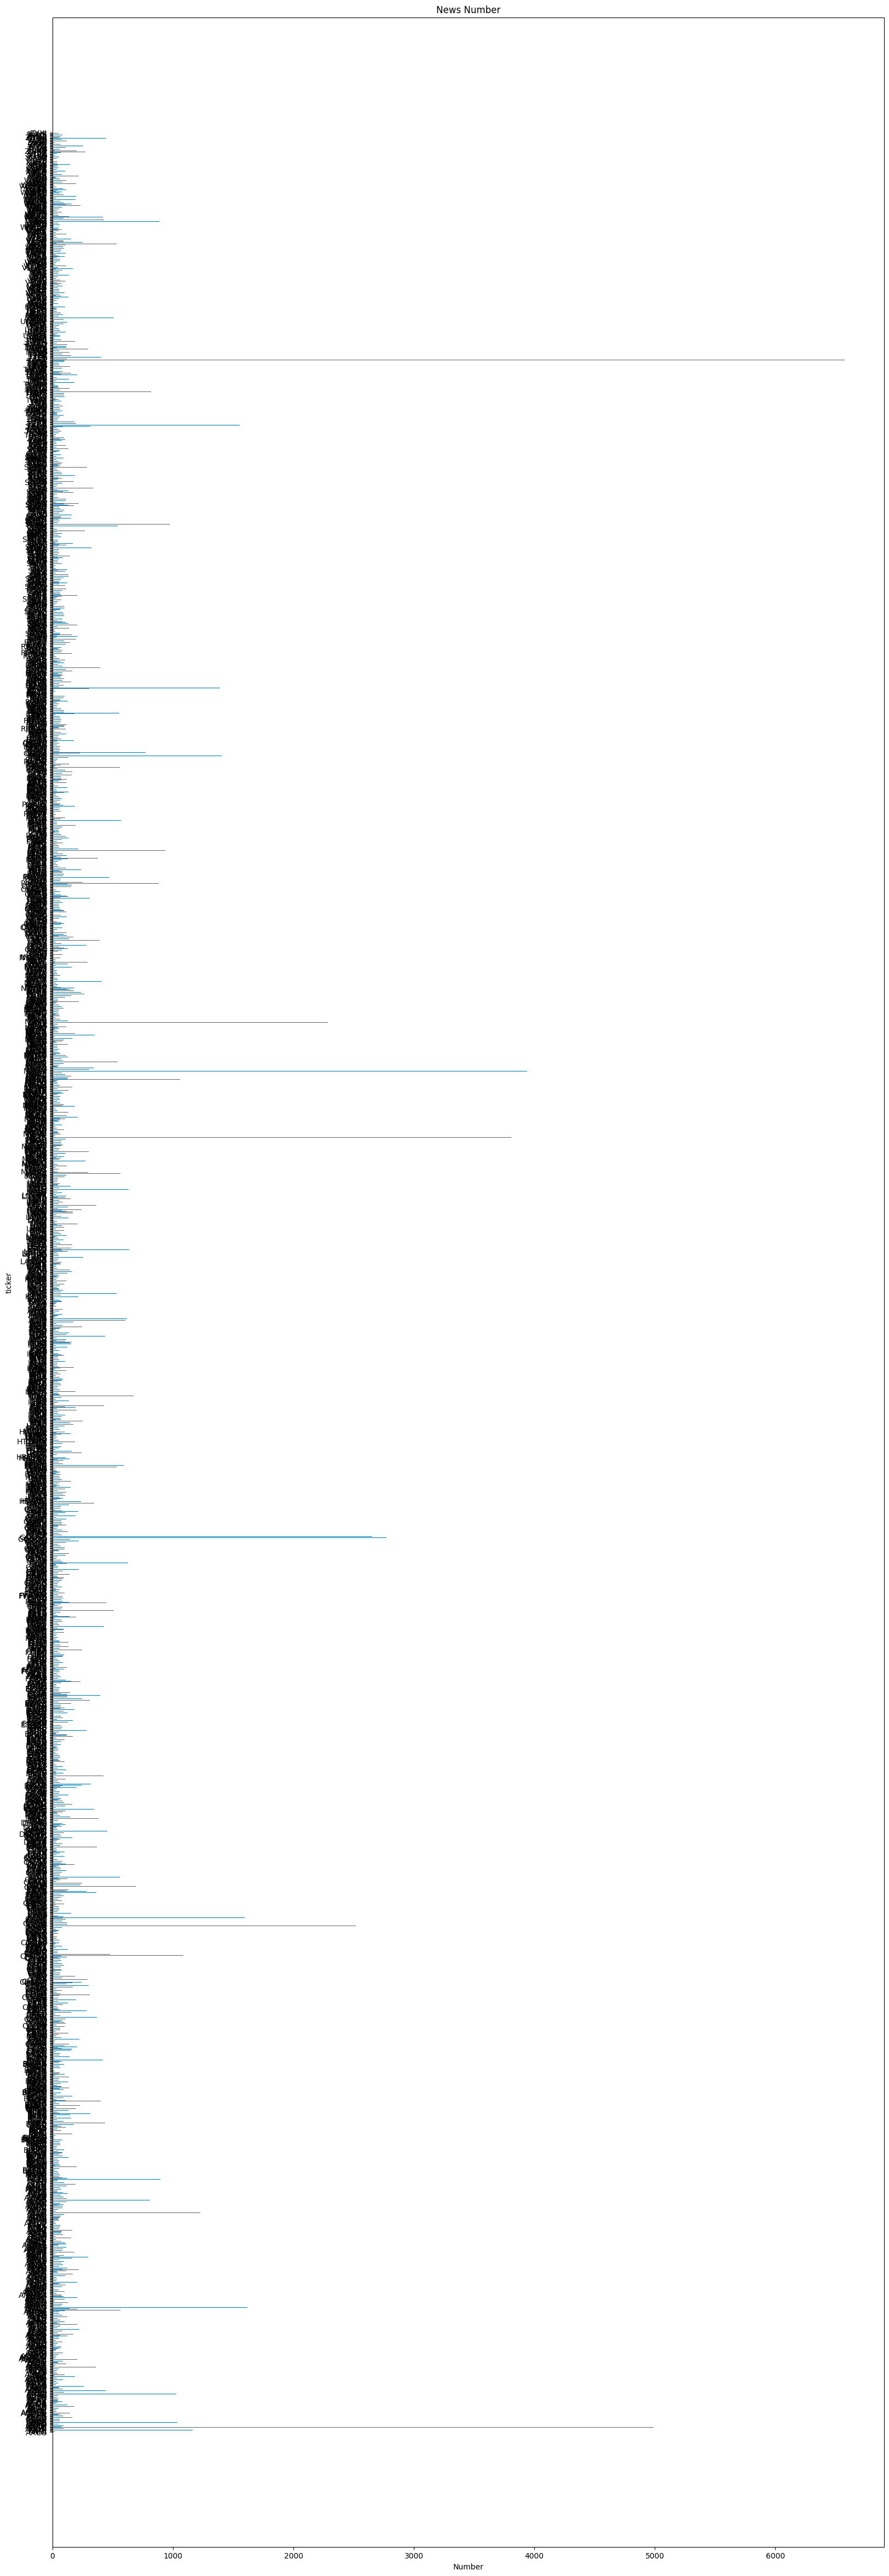

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import mplfinance as fplt

fig = plt.figure(figsize=(19.6, 60))
plt.barh(label_list,value_list,height=0.4 ,align='edge')
plt.title("News Number")
plt.xlabel("Number")
plt.ylabel("ticker")
plt.show()

# Topic visualization

In [1]:
from top2vec import Top2Vec

# model = Top2Vec(document_list[0]['negative_headline'])

/home/ssu36/anaconda3/envs/tiger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


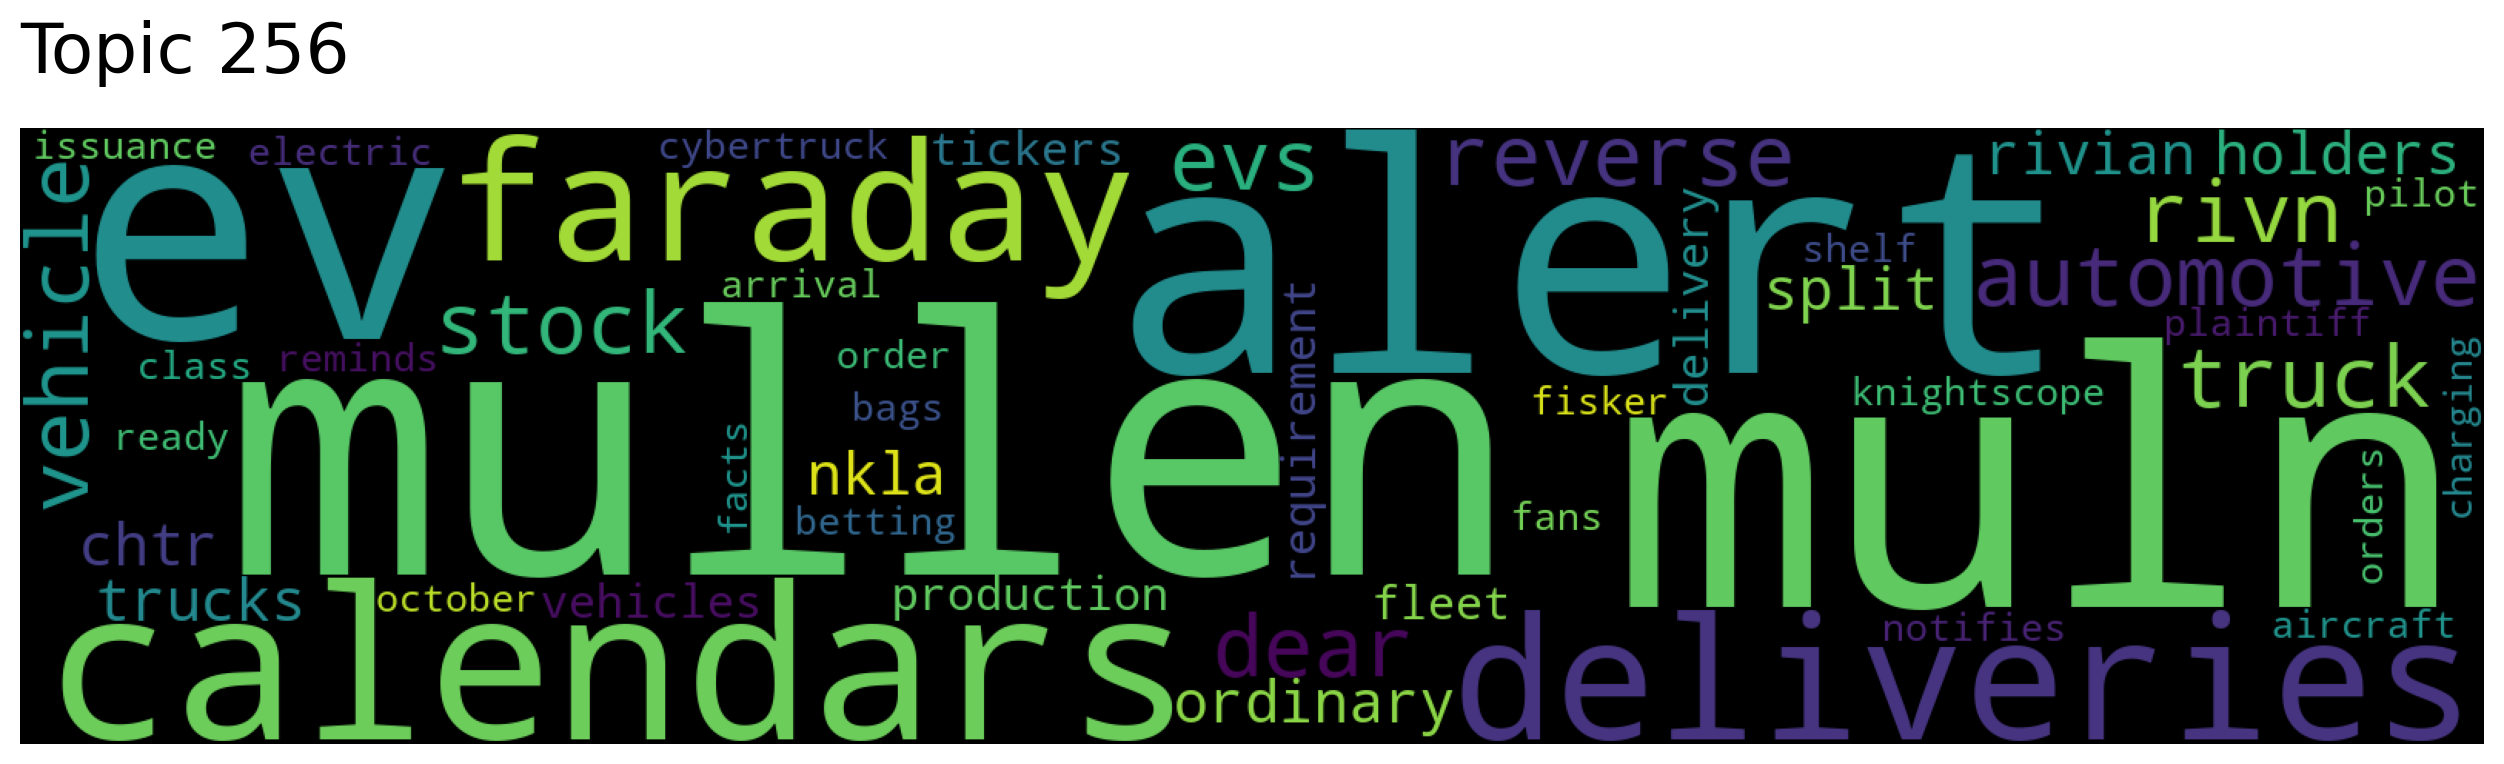

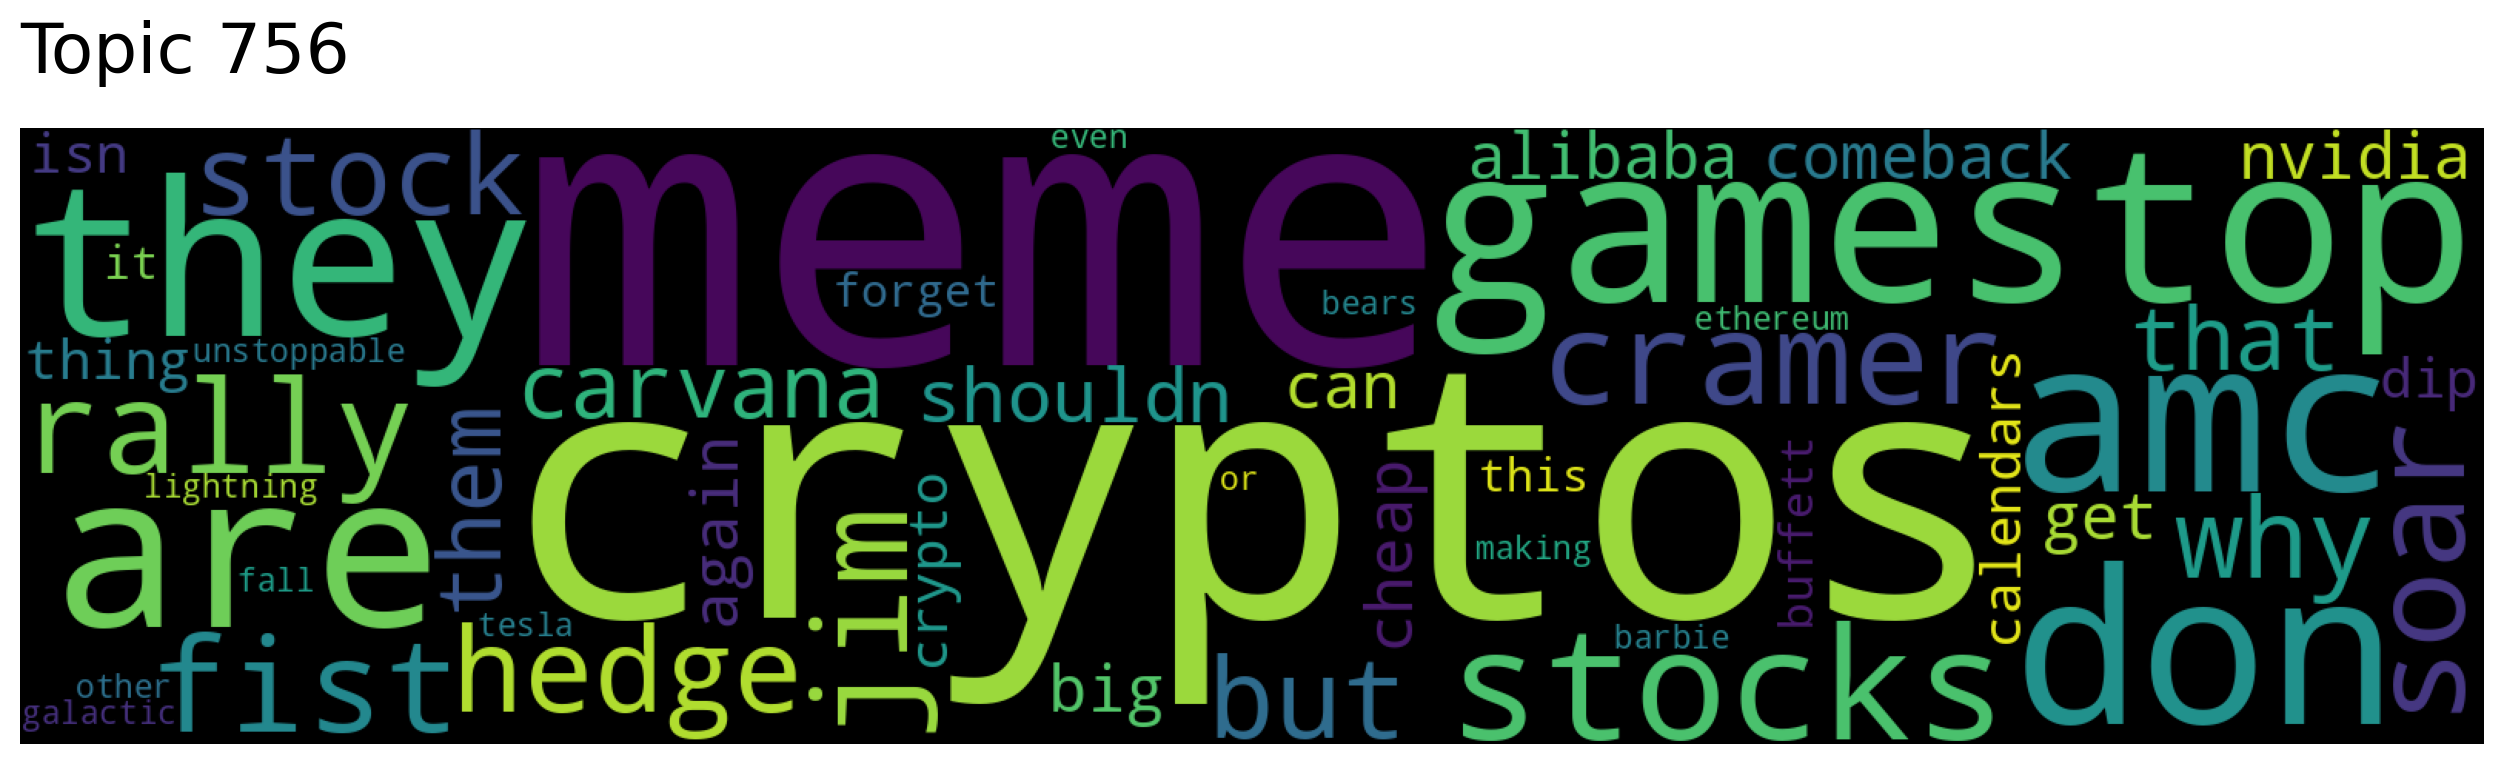

In [27]:
#원하는 데이터로 학습한 모델 load
n
egative_model = Top2Vec.load("/home/ssu36/tiger/NH_competition/data_2_negative_headline")

topic_words, word_scores, topic_scores, topic_nums = negative_model.search_topics(keywords=["stock"], num_topics= 2)
for topic in topic_nums:
    negative_model.generate_topic_wordcloud(topic)

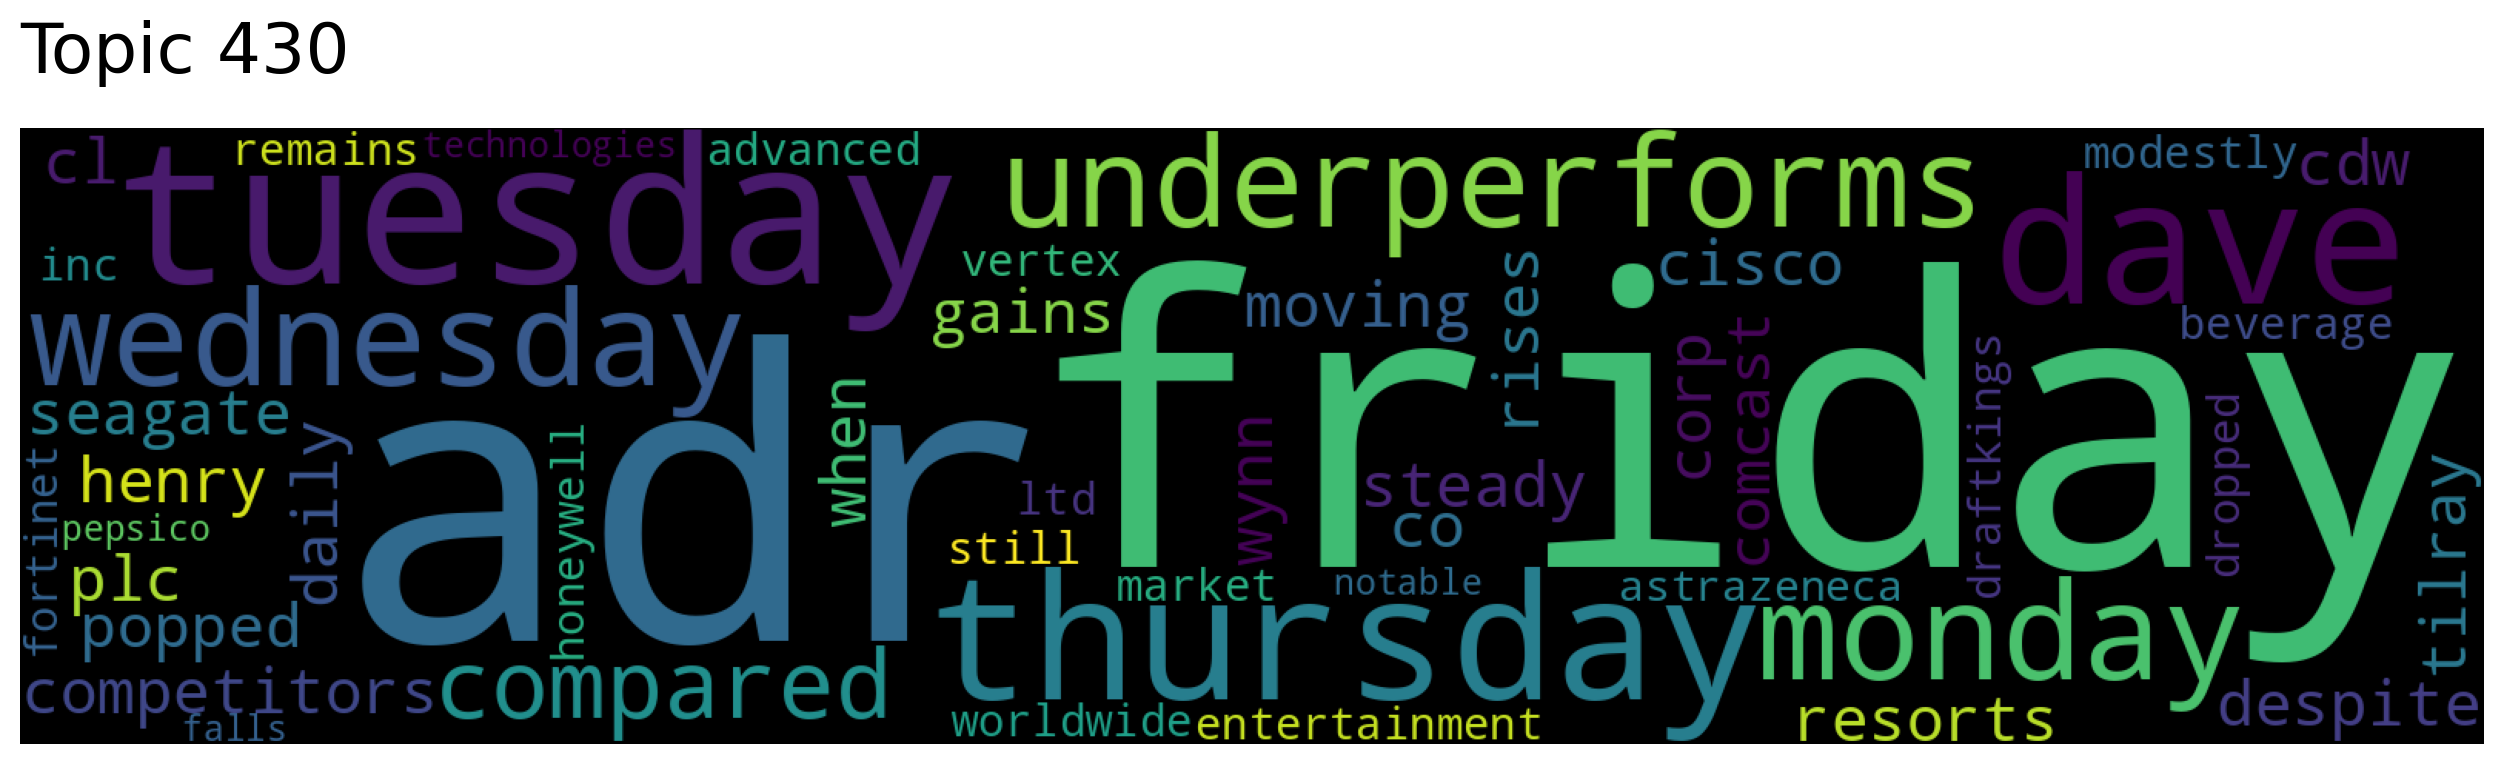

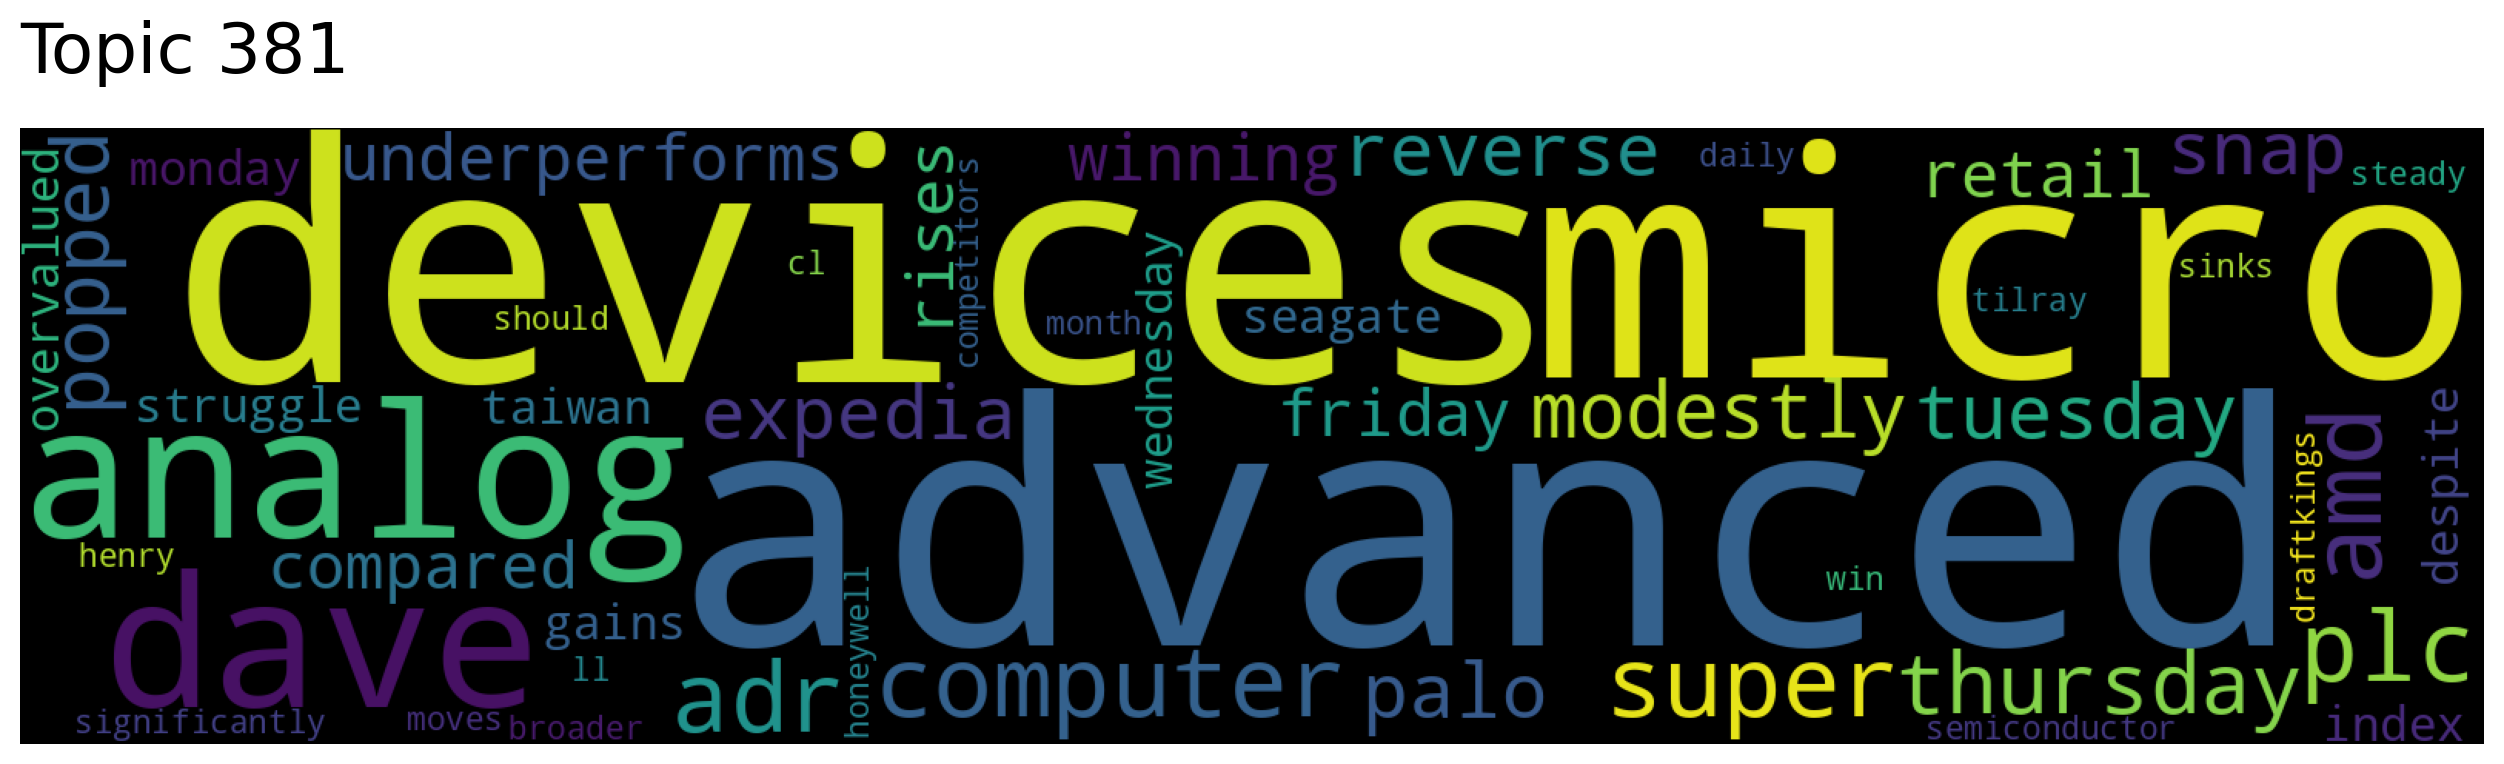

In [28]:

postive_motel = Top2Vec.load("/home/ssu36/tiger/NH_competition/data_2_postive_headline")

topic_words, word_scores, topic_scores, topic_nums = postive_motel.search_topics(keywords=["stock"], num_topics=2)
for topic in topic_nums:
    postive_motel.generate_topic_wordcloud(topic)